In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean
import cmaps

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=15, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)
client


2023-06-14 11:47:49,378 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ytmm42d4', purging
2023-06-14 11:47:49,379 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_wsdjaer', purging
2023-06-14 11:47:49,380 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-everqr7l', purging
2023-06-14 11:47:49,380 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5kvu_iku', purging
2023-06-14 11:47:49,381 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-gtrvhkzd', purging
2023-06-14 11:47:49,381 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wm16an8e', purging
2023-06-14 11:47:49,381 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h0vxd_ep', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 15
Total threads: 15,Total memory: 93.09 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35037,Workers: 15
Dashboard: http://127.0.0.1:8787/status,Total threads: 15
Started: Just now,Total memory: 93.09 GiB
Comm: tcp://127.0.0.1:37353,Total threads: 1
Dashboard: http://127.0.0.1:38135/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:41217,


In [3]:
import geopandas as gpd
coastline = gpd.read_file('~/storage/VECTORIAL/limites/chilecontinental.gpkg')
# Load grid
gridd0 = xr.open_dataset('~/storage/SEQUIA/crocod0_grd.nc').load()
gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()

/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [111]:
# Load rund0 simulation 
pathsavg_rund0 = sorted(glob('data/DESALADORAS_RUND0/avg/*avg*Y2001*'))
rund0_avg      = xr.open_mfdataset(pathsavg_rund0, parallel=True)[['temp','hbl','zeta','h','hc','Cs_r']]
rund0_avg      = fix_crocotime(rund0_avg, YORIG='1949-12-30 23:59:50').load()
rund0_coquimbo = croco_selpoint(rund0_avg, 360-71.316, -29.942)

In [112]:
z = rhopoints_depths(rund0_avg.h, rund0_avg.zeta, rund0_avg.s_rho, rund0_avg.Cs_r, rund0_avg.hc)

In [42]:
# Load rund1 simulation 
pathsavg_rund1 = sorted(glob('data/DESALADORAS_RUND1/*avg*Y2001*'))
rund1_avg      = xr.open_mfdataset(pathsavg_rund1, parallel=True).temp.isel(s_rho=-1)
rund1_avg      = fix_crocotime(rund1_avg, YORIG='1949-12-30 23:59:50').load()
rund1_coquimbo = croco_selpoint(rund1_avg, 360-71.316, -29.942)

In [39]:
# load stations time series
coquimbo = [pd.read_csv(p, parse_dates=True, index_col=0) for p in glob('/home/lucasg/storage/ESTACIONES/*.csv')]
coquimbo = pd.concat(coquimbo, axis=1)['TSM[°C]']["2001"].resample('6h').mean()#['2001':'2006']


Text(0.5, 0, '')

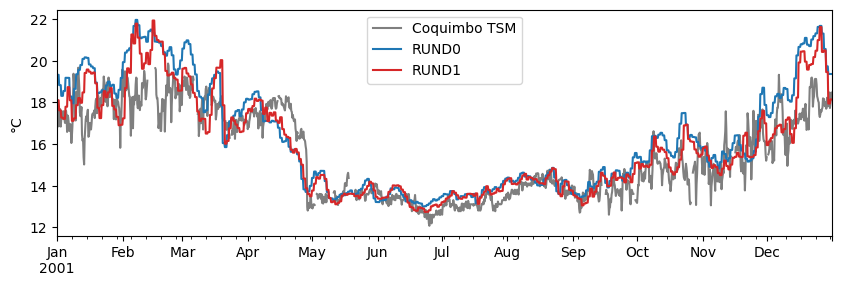

In [53]:
plt.figure(figsize=(10,3), facecolor='w', dpi=100)

coquimbo.plot(color='k', alpha=0.5, label='Coquimbo TSM')
rund0_coquimbo.to_series().reindex(coquimbo.index, method='nearest').plot(color='tab:blue', label='RUND0')
rund1_coquimbo.to_series().reindex(coquimbo.index, method='nearest').plot(color='tab:red', label='RUND1')
plt.legend()
plt.ylabel('°C')
plt.xlabel('')


In [131]:
mask = ~np.isnan(z.where(z>=-rund0_avg.hbl))

In [134]:
# Load rund0 simulation 
pathsavg_rund0 = sorted(glob('data/DESALADORAS_RUND0/*dia*Y2001*'))
rund0_forc      = xr.open_mfdataset(pathsavg_rund0, parallel=True)
rund0_forc      = fix_crocotime(rund0_forc, YORIG='1949-12-30 23:59:50').load()

pathsavg_rund0 = sorted(glob('data/DESALADORAS_RUND0/*dia*Y2001*'))
dvars = ["temp_xadv","temp_yadv","temp_vadv","temp_hmix","temp_vmix","temp_forc","temp_rate"]
rund0_diags      = xr.open_mfdataset(pathsavg_rund0, parallel=True,
                                     preprocess=lambda ds: ds[dvars].where(mask).mean('s_rho'))
rund0_diags      = fix_crocotime(rund0_diags, YORIG='1949-12-30 23:59:50')

2023-06-14 12:47:11,157 - distributed.worker_memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 5.22 GiB -- Worker memory limit: 6.21 GiB
2023-06-14 12:47:11,270 - distributed.worker_memory - WARNING - Worker is at 87% memory usage. Pausing worker.  Process memory: 5.43 GiB -- Worker memory limit: 6.21 GiB
2023-06-14 12:47:16,413 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.43 GiB -- Worker memory limit: 6.21 GiB
2023-06-14 12:47:16,414 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

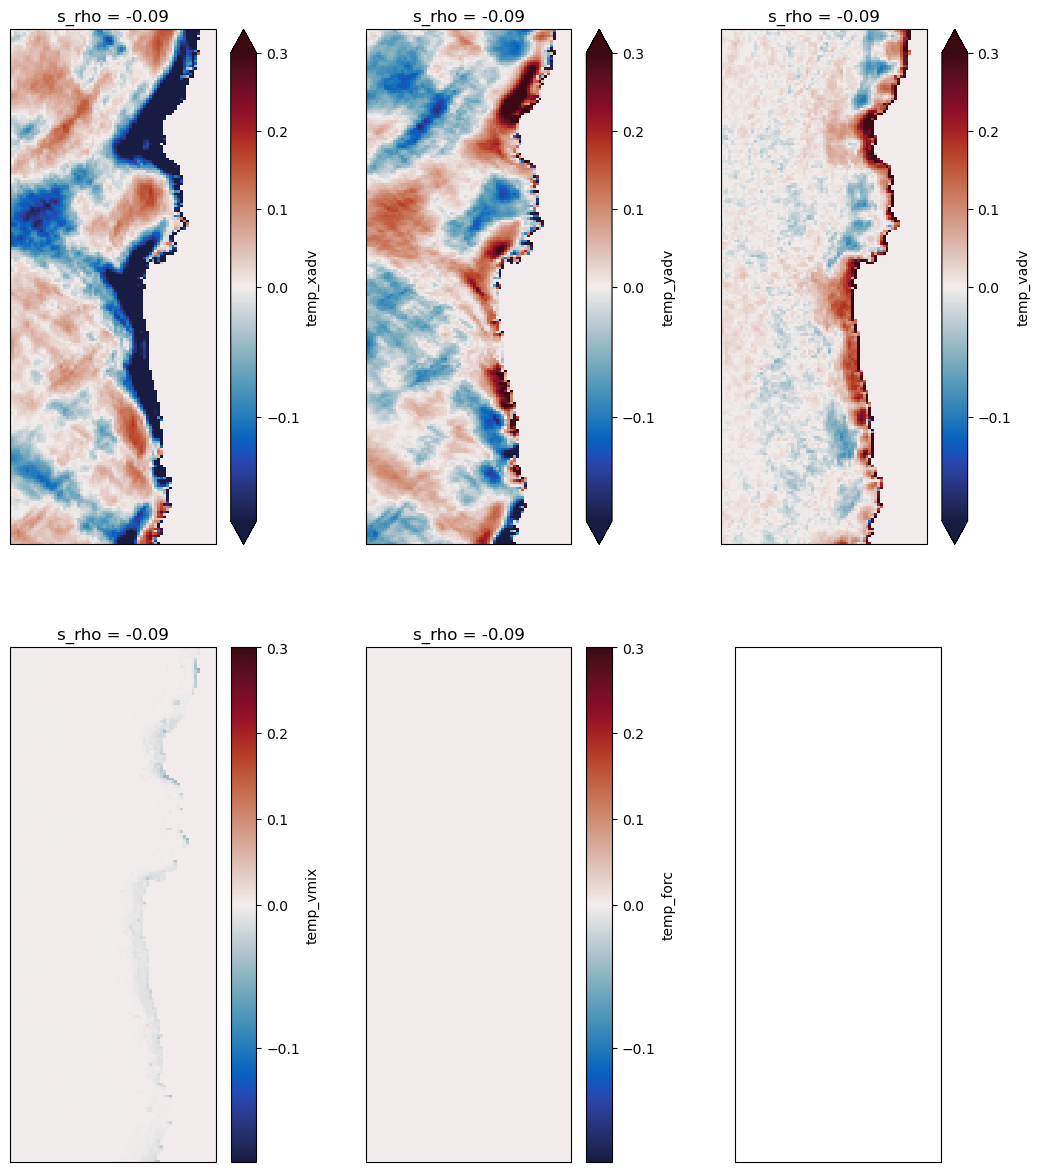

In [104]:
fig, ax = plt.subplots(2,3, sharex=True ,sharey=True, subplot_kw={'projection':ccrs.PlateCarree()}, facecolor='w', dpi=100, figsize=(13,15))
for i,k in enumerate(["temp_xadv","temp_yadv","temp_vadv","temp_vmix","temp_forc"]):
    axis = ax.ravel()[i]
    axis.set_extent([-73,-71,-33,-28])
    (3600*rund0_diags_avg[k]).plot(ax=axis, x='lon_rho', y='lat_rho', norm=mcolors.TwoSlopeNorm(0,-0.18,0.3), cmap=cmocean.cm.balance)